## Land Cover Data

**Author**: Michelle Sims

**Date:** 11/24/20

**Data Source:** USGS National Land Cover Database

**Description:** NLCD is generated in cooperation with the Multi-Resolution Land Characteristics Consortium (MRLC) a partnership of Federal agencies working together to produce current, nationally consistent, land cover products for all 50 states and Puerto Rico. NLCD is used for thousands of applications that require information on landcover location or where it is changing.

The National Land Cover Database (NLCD) provides nationwide data on land cover and land cover change at a 30m resolution with a 16-class legend based on a modified Anderson Level II classification system. NLCD 2016 represents the latest evolution of NLCD land cover products focused on providing innovative land cover and land cover change data for the Nation.

**Source Link**: https://www.mrlc.gov/data?f%5B0%5D=category%3Aland%20cover&f%5B1%5D=year%3A2016

In [18]:
#Dependencies
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.features import rasterize
import rasterio.transform
import rasterio.mask
import rasterio.warp
import rasterio.windows
import rioxarray as rxr
from pyproj import CRS
import pyproj
import sys
import xarray as xr
import os
import seaborn as sns

In [17]:
#pip install seaborn

  Using cached seaborn-0.11.0-py3-none-any.whl (283 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Set data directory
datadir = os.sep.join(['Data/'])

### Import Data

In [3]:
filepath = os.sep.join([datadir, 'CH4_Emitters_All.geojson'])

In [4]:
#Import data on VISTA Emitter Points
ch4_emitters = gpd.read_file(filepath)

In [5]:
#Check Data
ch4_emitters.head()

,City,Latitude,Longitude,Source,State,Vista_Date,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,TROPOMI_CH4_Min,TROPOMI_CH4_Max,TROPOMI_CH4_Mean,TROPOMI_CH4_Count,TROPOMI_CH4_MEDIAN,County,geometry
0,Oakdale,37.72799,-120.89865,CalRecycle,CA,2019-08-20,4B Biological Treatment of Solid Waste,"3D Ag, LLC",Composting Sites,CMP000001,1866.219667,1869.152088,1867.685878,2,1867.685878,None,"POLYGON ((-120.90558 37.82784, -120.89172 37.8..."
1,Lake Elsinore,33.70999,-117.32864,CalRecycle,CA,2019-08-20,4B Biological Treatment of Solid Waste,"A. Lua Recycling, Inc.",Composting Sites,CMP000002,1875.187369,1880.163061,1877.675215,2,1877.675215,None,"POLYGON ((-117.33593 33.80981, -117.32135 33.8..."
2,Martinez,38.01667,-122.13333,CalRecycle,CA,2019-08-20,4B Biological Treatment of Solid Waste,Acme Composting Compost Facility,Composting Sites,CMP000003,1842.263902,1845.817238,1844.040570,2,1844.040570,None,"POLYGON ((-122.14023 38.11652, -122.12643 38.1..."
3,Los Angeles (City),34.03281,-118.35424,CalRecycle,CA,2019-08-20,4B Biological Treatment of Solid Waste,Adams Garden Supply,Composting Sites,CMP000004,1854.870680,1895.935669,1880.347071,3,1890.234865,None,"POLYGON ((-118.36150 34.13264, -118.34698 34.1..."
4,Hesperia,34.44517,-117.29007,CalRecycle,CA,2019-08-20,4B Biological Treatment of Solid Waste,Advance Disposal Center for the Environm,Composting Sites,CMP000005,1867.374578,1868.685923,1868.030250,2,1868.030250,None,"POLYGON ((-117.29730 34.54500, -117.28284 34.5..."


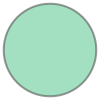

In [8]:
#Look at geometry shape
ch4_emitters['geometry'][18000]

In [11]:
#Check Area of Buffer
np.mean(ch4_emitters['geometry'].area)

0.03142145490114325

In [12]:
#Check min area
np.min(ch4_emitters['geometry'].area)

0.014581743158975095

In [13]:
#Check max area
np.max(ch4_emitters['geometry'].area)

0.16113223864430365

In [7]:
#Check CRS
ch4_emitters.crs

{'init': 'epsg:4326'}

### Extracting Land Cover Classifications

Unfortunately, due to the large size of the land cover file, it kept killing my kernel on python. So I calculated these zonal statistics and zonal histogram in QGIS, following the steps below. 

**Steps:**

1. Load Land Cover data for California. The Raster is in Albers projection, and the CRS was not recognized by QGIS. I first assigned a projection to the data layer (Raster > Projections > Assign Projection), and assigned it EPSG:5070 (NAD83 Conus Albers). 
2. I then reprojected it to WGS 84 (Raster > Projections > Warp). I used the Nearest neighbor resampling method. 
3. Load CH4 Emitter dataset, which contains polygons specifying the location of emitters from the VISTA dataset. 
4. I used the zonal statistics algorithm, which calculates the statistics of a raster layer for each feature of an overlapping polygon layer. I used this to calculate the majority pixel value within the polygon (i.e. majority land use classification within the polygon). 
5. I used the zonal histogram algorithm to calculate the count of each unique value from the land cover raster layer contained within the CH4 emitter polygons. This will tell us the proportion of each land use type within each polygon. 

#### Land Cover Classifications:

Source Link: https://www.mrlc.gov/data/legends/national-land-cover-database-2016-nlcd2016-legend

11: Open Water- areas of open water, generally with less than 25% cover of vegetation or soil. <br>

12: Perennial Ice/Snow- areas characterized by a perennial cover of ice and/or snow, generally greater than 25% of total cover. <br>

21: Developed, Open Space- areas with a mixture of some constructed materials, but mostly vegetation in the form of lawn grasses. Impervious surfaces account for less than 20% of total cover. These areas most commonly include large-lot single-family housing units, parks, golf courses, and vegetation planted in developed settings for recreation, erosion control, or aesthetic purposes. <br>

22: Developed, Low Intensity- areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 20% to 49% percent of total cover. These areas most commonly include single-family housing units. <br>

23: Developed, Medium Intensity -areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 50% to 79% of the total cover. These areas most commonly include single-family housing units. <br>

24: Developed High Intensity-highly developed areas where people reside or work in high numbers. Examples include apartment complexes, row houses and commercial/industrial. Impervious surfaces account for 80% to 100% of the total cover. <br>

31: Barren Land (Rock/Sand/Clay) - areas of bedrock, desert pavement, scarps, talus, slides, volcanic material, glacial debris, sand dunes, strip mines, gravel pits and other accumulations of earthen material. Generally, vegetation accounts for less than 15% of total cover. <br>

41: Deciduous Forest- areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. More than 75% of the tree species shed foliage simultaneously in response to seasonal change. <br>

42: Evergreen Forest- areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. More than 75% of the tree species maintain their leaves all year. Canopy is never without green foliage. <br>

43: Mixed Forest- areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. Neither deciduous nor evergreen species are greater than 75% of total tree cover. <br>

51: Dwarf Scrub- Alaska only areas dominated by shrubs less than 20 centimeters tall with shrub canopy typically greater than 20% of total vegetation. This type is often co-associated with grasses, sedges, herbs, and non-vascular vegetation. <br>

52: Shrub/Scrub- areas dominated by shrubs; less than 5 meters tall with shrub canopy typically greater than 20% of total vegetation. This class includes true shrubs, young trees in an early successional stage or trees stunted from environmental conditions. <br>

71: Grassland/Herbaceous- areas dominated by gramanoid or herbaceous vegetation, generally greater than 80% of total vegetation. These areas are not subject to intensive management such as tilling, but can be utilized for grazing. <br>

72: Sedge/Herbaceous- Alaska only areas dominated by sedges and forbs, generally greater than 80% of total vegetation. This type can occur with significant other grasses or other grass like plants, and includes sedge tundra, and sedge tussock tundra. <br>

73: Lichens- Alaska only areas dominated by fruticose or foliose lichens generally greater than 80% of total vegetation. <br>

74: Moss- Alaska only areas dominated by mosses, generally greater than 80% of total vegetation. <br>

81: Pasture/Hay-areas of grasses, legumes, or grass-legume mixtures planted for livestock grazing or the production of seed or hay crops, typically on a perennial cycle. Pasture/hay vegetation accounts for greater than 20% of total vegetation. <br>

82: Cultivated Crops -areas used for the production of annual crops, such as corn, soybeans, vegetables, tobacco, and cotton, and also perennial woody crops such as orchards and vineyards. Crop vegetation accounts for greater than 20% of total vegetation. This class also includes all land being actively tilled. <br>

90: Woody Wetlands- areas where forest or shrubland vegetation accounts for greater than 20% of vegetative cover and the soil or substrate is periodically saturated with or covered with water. <br>

95: Emergent Herbaceous Wetlands- Areas where perennial herbaceous vegetation accounts for greater than 80% of vegetative cover and the soil or substrate is periodically saturated with or covered with water. <br>

### Data Cleaning

Clean Zonal Histogram Data

In [183]:
filepath = os.sep.join([datadir, 'CH4_Emitters_land_use_histo.geojson'])

In [184]:
#Import CH4 emitter data with zonal histogram
ch4_zonal_hist = gpd.read_file(filepath)

In [19]:
ch4_zonal_hist.head()

,City,Latitude,Longitude,Source,State,Vista_Date,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,...,HISTO_41,HISTO_42,HISTO_43,HISTO_52,HISTO_71,HISTO_81,HISTO_82,HISTO_90,HISTO_95,geometry
0,Oakdale,37.72799,-120.89865,CalRecycle,CA,2019-08-20,4B Biological Treatment of Solid Waste,"3D Ag, LLC",Composting Sites,CMP000001,...,0,0,0,0,7802,21666,175939,1356,656,"POLYGON ((-120.90558 37.82784, -120.89172 37.8..."
1,Lake Elsinore,33.70999,-117.32864,CalRecycle,CA,2019-08-20,4B Biological Treatment of Solid Waste,"A. Lua Recycling, Inc.",Composting Sites,CMP000002,...,9,517,774,102301,77494,782,586,513,328,"POLYGON ((-117.33593 33.80981, -117.32135 33.8..."
2,Martinez,38.01667,-122.13333,CalRecycle,CA,2019-08-20,4B Biological Treatment of Solid Waste,Acme Composting Compost Facility,Composting Sites,CMP000003,...,31,2864,36571,34232,45775,0,755,310,17967,"POLYGON ((-122.14023 38.11652, -122.12643 38.1..."
3,Los Angeles (City),34.03281,-118.35424,CalRecycle,CA,2019-08-20,4B Biological Treatment of Solid Waste,Adams Garden Supply,Composting Sites,CMP000004,...,0,240,700,9751,614,1706,496,12,116,"POLYGON ((-118.36150 34.13264, -118.34698 34.1..."
4,Hesperia,34.44517,-117.29007,CalRecycle,CA,2019-08-20,4B Biological Treatment of Solid Waste,Advance Disposal Center for the Environm,Composting Sites,CMP000005,...,4,0,1,123293,5467,0,112,2057,431,"POLYGON ((-117.29730 34.54500, -117.28284 34.5..."


In [185]:
ch4_zonal_hist.columns

Index(['City', 'Latitude', 'Longitude', 'Source', 'State', 'Vista_Date',
       'Vista_IPCC', 'Vista_Name', 'Vista_SType', 'Vista_ID',
       'TROPOMI_CH4_Min', 'TROPOMI_CH4_Max', 'TROPOMI_CH4_Mean',
       'TROPOMI_CH4_Count', 'TROPOMI_CH4_MEDIAN', 'County', 'HISTO_0',
       'HISTO_11', 'HISTO_12', 'HISTO_21', 'HISTO_22', 'HISTO_23', 'HISTO_24',
       'HISTO_31', 'HISTO_41', 'HISTO_42', 'HISTO_43', 'HISTO_52', 'HISTO_71',
       'HISTO_81', 'HISTO_82', 'HISTO_90', 'HISTO_95', 'geometry'],
      dtype='object')

In the histogram categories, we can see that there is a '0' land class, which doesn't correspond to an actual land class. Upon further inspection, I realized that this is because some of the buffers fall outside of California, and our raster is clipped to California. To effectively 'clip' the buffers to be within the bounds of California, I will remove this column before calculating the pixel count totals. 

In [186]:
#Drop pixels that call outside of California
ch4_zonal_hist.drop(columns = 'HISTO_0', inplace = True)

In [200]:
ch4_zonal_hist.iloc[:, 16:32]

,HISTO_11,HISTO_12,HISTO_21,HISTO_22,HISTO_23,HISTO_24,HISTO_31,HISTO_41,HISTO_42,HISTO_43,HISTO_52,HISTO_71,HISTO_81,HISTO_82,HISTO_90,HISTO_95
0,852,0,14736,16743,29090,6216,741,0,0,0,0,7802,21666,175939,1356,656
1,10457,0,36144,26008,17578,1747,693,9,517,774,102301,77494,782,586,513,328
2,40679,0,26978,30246,29088,10128,192,31,2864,36571,34232,45775,0,755,310,17967
3,386,0,21384,39360,131085,69847,170,0,240,700,9751,614,1706,496,12,116
4,860,0,38811,72054,26138,4752,1876,4,0,1,123293,5467,0,112,2057,431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234571,1192,0,21544,47528,132989,51243,917,0,980,1562,17373,2496,2608,2233,362,935
234572,294,0,39151,71695,97908,9263,3391,0,19,39,33401,27490,2748,297,434,1765
234573,288,0,36825,69347,93877,9915,3395,0,26,50,40300,31931,1773,253,263,1021
234574,151,0,34609,32415,16595,1000,2547,7,816,475,119624,66686,6264,12614,598,387


In [220]:
#Create a row that contains the total pixel count in each polygon. We can use this to calculate the proportion 
#of pixels that are each land use category. 
ch4_zonal_hist['TOTAL'] = ch4_zonal_hist.iloc[:, 16:32].sum(axis = 1)

In [229]:
ch4_zonal_hist.iloc[:, 16:34].head()

,HISTO_11,HISTO_12,HISTO_21,HISTO_22,HISTO_23,HISTO_24,HISTO_31,HISTO_41,HISTO_42,HISTO_43,HISTO_52,HISTO_71,HISTO_81,HISTO_82,HISTO_90,HISTO_95,geometry,TOTAL
0,852,0,14736,16743,29090,6216,741,0,0,0,0,7802,21666,175939,1356,656,"POLYGON ((-120.90558 37.82784, -120.89172 37.8...",275797
1,10457,0,36144,26008,17578,1747,693,9,517,774,102301,77494,782,586,513,328,"POLYGON ((-117.33593 33.80981, -117.32135 33.8...",275931
2,40679,0,26978,30246,29088,10128,192,31,2864,36571,34232,45775,0,755,310,17967,"POLYGON ((-122.14023 38.11652, -122.12643 38.1...",275816
3,386,0,21384,39360,131085,69847,170,0,240,700,9751,614,1706,496,12,116,"POLYGON ((-118.36150 34.13264, -118.34698 34.1...",275867
4,860,0,38811,72054,26138,4752,1876,4,0,1,123293,5467,0,112,2057,431,"POLYGON ((-117.29730 34.54500, -117.28284 34.5...",275856


In [207]:
#Create column that shows each land cover class as a percentage of the total, rather than a total count
ch4_zonal_hist['open_water_perc'] = ch4_zonal_hist.loc[:, 'HISTO_11']/ch4_zonal_hist.loc[:, 'TOTAL']
ch4_zonal_hist['ice_snow_perc'] = ch4_zonal_hist.loc[:, 'HISTO_12']/ch4_zonal_hist.loc[:, 'TOTAL']
ch4_zonal_hist['developed_open_space_perc'] = ch4_zonal_hist.loc[:, 'HISTO_21']/ch4_zonal_hist.loc[:, 'TOTAL']
ch4_zonal_hist['developed_low_int_perc'] = ch4_zonal_hist.loc[:, 'HISTO_22']/ch4_zonal_hist.loc[:, 'TOTAL']
ch4_zonal_hist['developed_med_int_perc'] = ch4_zonal_hist.loc[:, 'HISTO_23']/ch4_zonal_hist.loc[:, 'TOTAL']
ch4_zonal_hist['developed_high_int_perc'] = ch4_zonal_hist.loc[:, 'HISTO_24']/ch4_zonal_hist.loc[:, 'TOTAL']
ch4_zonal_hist['barren_land_perc'] = ch4_zonal_hist.loc[:, 'HISTO_31']/ch4_zonal_hist.loc[:, 'TOTAL']
ch4_zonal_hist['deciduous_forest_perc'] = ch4_zonal_hist.loc[:, 'HISTO_41']/ch4_zonal_hist.loc[:, 'TOTAL']
ch4_zonal_hist['evergreen_forest_perc'] = ch4_zonal_hist.loc[:, 'HISTO_42']/ch4_zonal_hist.loc[:, 'TOTAL']
ch4_zonal_hist['mixed_forest_perc'] = ch4_zonal_hist.loc[:, 'HISTO_43']/ch4_zonal_hist.loc[:, 'TOTAL']
ch4_zonal_hist['shrub_scrub_perc'] = ch4_zonal_hist.loc[:, 'HISTO_52']/ch4_zonal_hist.loc[:, 'TOTAL']
ch4_zonal_hist['grassland_herbaceous_perc'] = ch4_zonal_hist.loc[:, 'HISTO_71']/ch4_zonal_hist.loc[:, 'TOTAL']
ch4_zonal_hist['pasture_hay_perc'] = ch4_zonal_hist.loc[:, 'HISTO_81']/ch4_zonal_hist.loc[:, 'TOTAL']
ch4_zonal_hist['cultivated_crops_perc'] = ch4_zonal_hist.loc[:, 'HISTO_82']/ch4_zonal_hist.loc[:, 'TOTAL']
ch4_zonal_hist['woody_wetlands_perc'] = ch4_zonal_hist.loc[:, 'HISTO_90']/ch4_zonal_hist.loc[:, 'TOTAL']
ch4_zonal_hist['emergent_herbaceous_wetlands_perc'] = ch4_zonal_hist.loc[:, 'HISTO_95']/ch4_zonal_hist.loc[:, 'TOTAL']

In [208]:
#Check
ch4_zonal_hist.head()

,City,Latitude,Longitude,Source,State,Vista_Date,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,...,barren_land_perc,deciduous_forest_perc,evergreen_forest_perc,mixed_forest_perc,shrub_scrub_perc,grassland_herbaceous_perc,pasture_hay_perc,cultivated_crops_perc,woody_wetlands_perc,emergent_herbaceous_wetlands_perc
0,Oakdale,37.72799,-120.89865,CalRecycle,CA,2019-08-20,4B Biological Treatment of Solid Waste,"3D Ag, LLC",Composting Sites,CMP000001,...,0.002687,0.000000,0.000000,0.000000,0.000000,0.028289,0.078558,0.637929,0.004917,0.002379
1,Lake Elsinore,33.70999,-117.32864,CalRecycle,CA,2019-08-20,4B Biological Treatment of Solid Waste,"A. Lua Recycling, Inc.",Composting Sites,CMP000002,...,0.002511,0.000033,0.001874,0.002805,0.370748,0.280846,0.002834,0.002124,0.001859,0.001189
2,Martinez,38.01667,-122.13333,CalRecycle,CA,2019-08-20,4B Biological Treatment of Solid Waste,Acme Composting Compost Facility,Composting Sites,CMP000003,...,0.000696,0.000112,0.010384,0.132592,0.124112,0.165962,0.000000,0.002737,0.001124,0.065141
3,Los Angeles (City),34.03281,-118.35424,CalRecycle,CA,2019-08-20,4B Biological Treatment of Solid Waste,Adams Garden Supply,Composting Sites,CMP000004,...,0.000616,0.000000,0.000870,0.002537,0.035347,0.002226,0.006184,0.001798,0.000043,0.000420
4,Hesperia,34.44517,-117.29007,CalRecycle,CA,2019-08-20,4B Biological Treatment of Solid Waste,Advance Disposal Center for the Environm,Composting Sites,CMP000005,...,0.006801,0.000015,0.000000,0.000004,0.446947,0.019818,0.000000,0.000406,0.007457,0.001562


In [248]:
#Add column for total percentage
ch4_zonal_hist['total_perc'] = ch4_zonal_hist.iloc[:, 34:52].sum(axis = 1)

In [251]:
#Check to ensure percentages add up to 1
sum(ch4_zonal_hist['total_perc'] > 0.99)

234567

In [252]:
#Take a look at the observations which don't add up to one
ch4_zonal_hist[ch4_zonal_hist['total_perc'] < 0.99]

,City,Latitude,Longitude,Source,State,Vista_Date,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,...,deciduous_forest_perc,evergreen_forest_perc,mixed_forest_perc,shrub_scrub_perc,grassland_herbaceous_perc,pasture_hay_perc,cultivated_crops_perc,woody_wetlands_perc,emergent_herbaceous_wetlands_perc,total_perc
2245,Heber,32.699467,-115.445946,RAFIQ,CA,2019-11-10,3A1 Enteric Fermentation,Dairy Name Unknown,Feed Lot,FDL000069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2589,Imperial,32.676499,-115.545516,CalRecycle,None,2019-11-10,4A1 Managed Waste Disposal Sites,Calexico Solid Waste Site,Landfill,LNF000099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3746,None,32.761096,-114.829648,CEC,CA,2019-08-20,1B2 Oil and Natural Gas,Ogilby-Center Of The World,Natural Gas Station,COM000914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3754,None,32.672951,-115.403549,CEC,CA,2019-08-20,1B2 Oil and Natural Gas,All-American Canal,Natural Gas Station,COM000548,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
110292,Imperial,32.671305,-115.585688,CEC DOGGR,CA,7/12/2019,1B2 Oil and Natural Gas,"""Jacobs (nct-1)"" 1",Oil and Gas Well,OGW128137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
110295,Imperial,32.699710,-115.037765,CEC DOGGR,CA,7/12/2019,1B2 Oil and Natural Gas,"""Imperial"" 1",Oil and Gas Well,OGW174138,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
110296,Imperial,32.732319,-115.107434,CEC DOGGR,CA,7/12/2019,1B2 Oil and Natural Gas,IMPCO1,Oil and Gas Well,OGW174139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
145329,Santa Barbara,34.473950,-120.828858,CEC DOGGR,CA,7/12/2019,1B2 Oil and Natural Gas,1,Oil and Gas Well,OGW181279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
234435,Calexico,32.670486,-115.505105,CARB,CA,2019-08-20,4D1 & 4D2 Domestic Wastewater Treatment and Di...,Calexico,Wastewater Treatment Plant,WWT000010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Upon looking up these latitudes and longitudes, it appears they're right by the border (or in one case, in the ocean). I will leave them as NaN values. 

In [253]:
#Drop unnecessary columns
ch4_zonal_hist.drop(columns = ['HISTO_11', 'HISTO_12', 'HISTO_21', 'HISTO_22', 'HISTO_23', 
                             'HISTO_24', 'HISTO_31', 'HISTO_41', 'HISTO_42', 'HISTO_43', 'HISTO_52',
                             'HISTO_71', 'HISTO_81', 'HISTO_82', 'HISTO_90', 'HISTO_95', 'TOTAL'], inplace = True)

Now, we need to calculate the majority land use class for each buffer. 

In [289]:
#Create a for loop that iterates through each row and records the majority land use class for each buffer
for i in range(len(ch4_zonal_hist)):
    ch4_zonal_hist.loc[i, 'majority_class'] = np.argmax(ch4_zonal_hist.iloc[i, 17:33])

In [288]:
ch4_zonal_hist.iloc[0, 17:33]

open_water_perc                      0.00308923
ice_snow_perc                                 0
developed_open_space_perc             0.0534306
developed_low_int_perc                0.0607077
developed_med_int_perc                 0.105476
developed_high_int_perc               0.0225383
barren_land_perc                     0.00268676
deciduous_forest_perc                         0
evergreen_forest_perc                         0
mixed_forest_perc                             0
shrub_scrub_perc                              0
grassland_herbaceous_perc             0.0282889
pasture_hay_perc                      0.0785578
cultivated_crops_perc                  0.637929
woody_wetlands_perc                  0.00491666
emergent_herbaceous_wetlands_perc    0.00237856
Name: 0, dtype: object

In [293]:
#Check first couple rows
ch4_zonal_hist.iloc[0:4, 17:35]

,open_water_perc,ice_snow_perc,developed_open_space_perc,developed_low_int_perc,developed_med_int_perc,developed_high_int_perc,barren_land_perc,deciduous_forest_perc,evergreen_forest_perc,mixed_forest_perc,shrub_scrub_perc,grassland_herbaceous_perc,pasture_hay_perc,cultivated_crops_perc,woody_wetlands_perc,emergent_herbaceous_wetlands_perc,total_perc,majority_class
0,0.003089,0.0,0.053431,0.060708,0.105476,0.022538,0.002687,0.000000,0.000000,0.000000,0.000000,0.028289,0.078558,0.637929,0.004917,0.002379,1.0,13
1,0.037897,0.0,0.130989,0.094255,0.063704,0.006331,0.002511,0.000033,0.001874,0.002805,0.370748,0.280846,0.002834,0.002124,0.001859,0.001189,1.0,10
2,0.147486,0.0,0.097812,0.109660,0.105462,0.036720,0.000696,0.000112,0.010384,0.132592,0.124112,0.165962,0.000000,0.002737,0.001124,0.065141,1.0,11
3,0.001399,0.0,0.077516,0.142677,0.475175,0.253191,0.000616,0.000000,0.000870,0.002537,0.035347,0.002226,0.006184,0.001798,0.000043,0.000420,1.0,4


In [297]:
#Replace index values with names of majority class
ch4_zonal_hist['majority_class'].replace({0: 'Open Water', 
                                           1: 'Ice/Snow',
                                           2: 'Dev: Open Space',
                                           3: 'Dev: Low Int',
                                           4: 'Dev: Med Int',
                                           5: 'Dev: High Int',
                                           6: 'Barren Land',
                                           7: 'Deciduous Forest',
                                           8: 'Evergreen Forest',
                                           9: 'Mixed Forest',
                                           10: 'Shrub Scrub',
                                           11: 'Grassland',
                                           12: 'Pasture/Hay',
                                           13: 'Cultivated Crops',
                                           14: 'Woody Wetlands', 
                                           15: 'Herbaceous Wetlands'}, inplace = True)

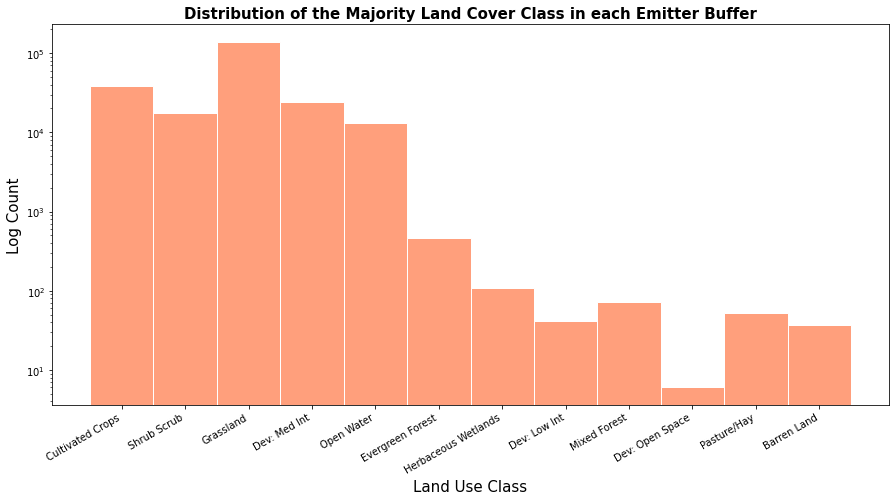

In [307]:
#Plot majority class
fig, ax = plt.subplots(figsize = (15,7))
sns.histplot(data = ch4_zonal_hist, x = 'majority_class', edgecolor = 'white', color = 'coral') 
plt.title('Distribution of the Majority Land Cover Class in each Emitter Buffer', fontweight='bold', size = 15)
ax.set_ylabel('Log Count', size = 15)
ax.set_xlabel('Land Use Class', size = 15)
ax.set_yscale('log')
plt.xticks(rotation = 30, ha = 'right')
plt.savefig('Data/majority_LUclass.png', bbox_inches = "tight")

In [309]:
#Get dummy for Land Use Majority
majority_dummies = pd.get_dummies(ch4_zonal_hist['majority_class'])

In [310]:
majority_dummies

,Barren Land,Cultivated Crops,Dev: Low Int,Dev: Med Int,Dev: Open Space,Evergreen Forest,Grassland,Herbaceous Wetlands,Mixed Forest,Open Water,Pasture/Hay,Shrub Scrub
0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
234571,0,0,0,1,0,0,0,0,0,0,0,0
234572,0,0,0,1,0,0,0,0,0,0,0,0
234573,0,0,0,1,0,0,0,0,0,0,0,0
234574,0,0,0,0,0,0,0,0,0,0,0,1


In [311]:
#Check length
len(majority_dummies) == len(ch4_zonal_hist)

True

In [312]:
#Create dummies for emitter type
type_dummies = pd.get_dummies(ch4_zonal_hist['Vista_SType'])

In [313]:
type_dummies.head()

,Composting Sites,Compressed Natural Gas Fueling Station,Dairy,Digester,Feed Lot,Landfill,Liquefied Natural Gas Fueling Station,Natural Gas Processing Plants,Natural Gas Station,Natural Gas Storage Field,Oil and Gas Facility Boundary,Oil and Gas Field Boundary,Oil and Gas Well,Power Plant,Refinery,Wastewater Treatment Plant
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Merge dummy dataframes with `ch4_zonal_hist` geodataframe. 

In [314]:
ch4_emitters_final = pd.concat([ch4_zonal_hist, majority_dummies, type_dummies], axis = 1)

In [47]:
#Check number of emitter types
len(ch4_emitters_final['Vista_SType'].unique())

16

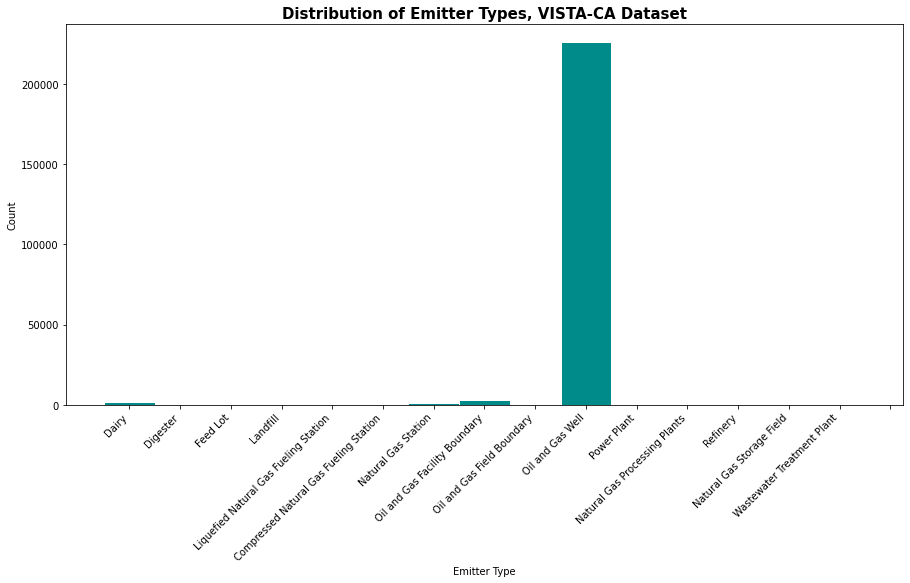

In [113]:
#Visualize distribution of emitter type
fig, ax = plt.subplots(figsize = (15,7))
bins = np.arange(1, 15 + 1.5) - 0.5
plt.hist(ch4_emitters_final['Vista_SType'], bins = bins, edgecolor = 'white', color = 'darkcyan')
plt.title('Distribution of Emitter Types, VISTA-CA Dataset', fontweight='bold', size = 15)
ax.set_xlabel('Emitter Type')
ax.set_ylabel('Count')
ax.set_xticks(bins + 0.5)
plt.xticks(rotation = 45, ha = 'right')
#plt.savefig('Data/emitter_type_distribution.png', bbox_inches = "tight")

Text(0, 0.5, '')

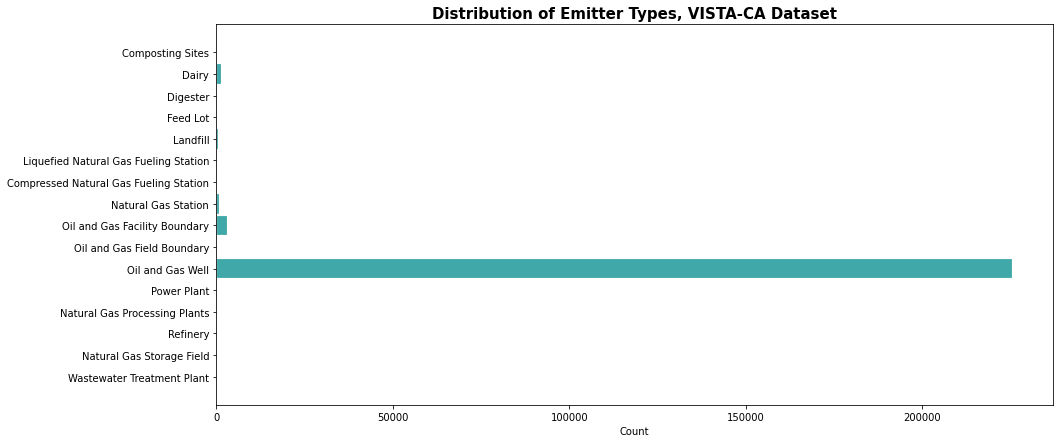

In [173]:
#Plot in sns
fig, ax = plt.subplots(figsize = (15,7))
sns.histplot(data = ch4_emitters_final, y = 'Vista_SType', edgecolor = 'white',  color = 'darkcyan')
plt.title('Distribution of Emitter Types, VISTA-CA Dataset', fontweight='bold', size = 15)
ax.set_ylabel('')
#plt.savefig('Data/emitter_type_distribution_sns.png', bbox_inches = "tight")

In [70]:
#Remove oil and gas well so we can take a closer look at the distribution of the other types of emitters
ch4_remove_ogwell = ch4_emitters_final[ch4_emitters_final['Vista_SType'] != 'Oil and Gas Well']

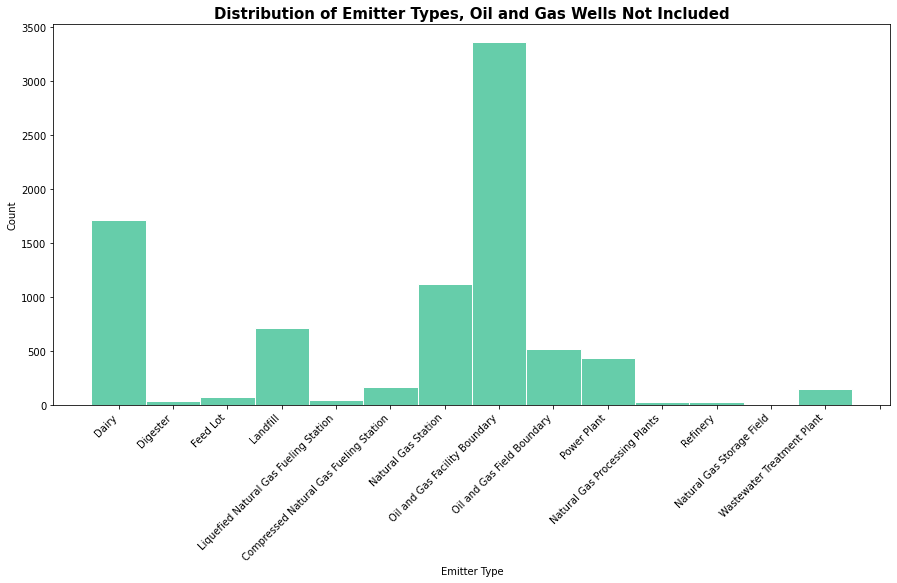

In [111]:
# Plot without Oil and Gas well
fig, ax = plt.subplots(figsize = (15,7))
bins = np.arange(1, 14 + 1.5) - 0.5
plt.hist(ch4_remove_ogwell['Vista_SType'], 
            bins = bins, edgecolor = 'white', color = 'mediumaquamarine')
plt.title('Distribution of Emitter Types, Oil and Gas Wells Not Included', fontweight='bold', size = 15)
ax.set_xlabel('Emitter Type')
ax.set_ylabel('Count')
ax.set_xticks(bins + 0.5)
plt.xticks(rotation = 45, ha = 'right')
#plt.savefig('Data/emitter_distribution_ogremoved.png', bbox_inches = "tight")

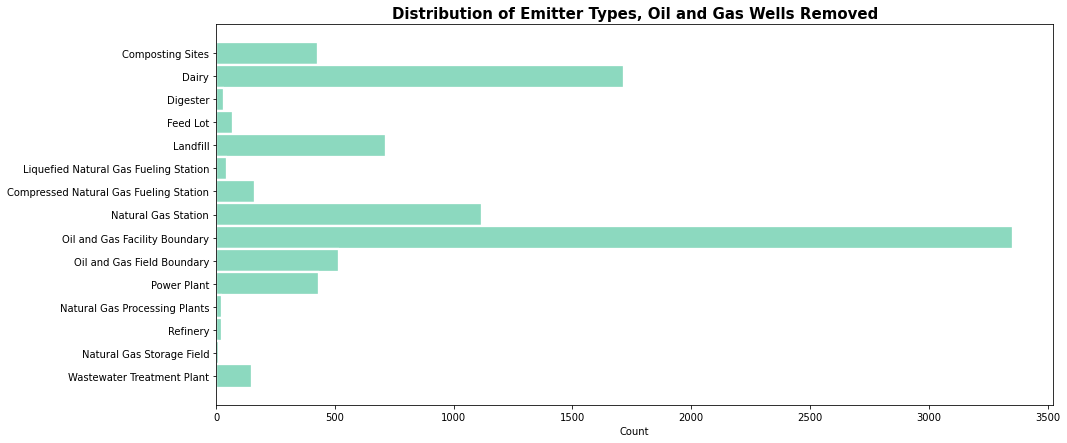

In [110]:
#Plot in SNS
fig, ax = plt.subplots(figsize = (15,7))
sns.histplot(data = ch4_remove_ogwell, y = 'Vista_SType', edgecolor = 'white',  color = 'mediumaquamarine')
plt.title('Distribution of Emitter Types, Oil and Gas Wells Removed', fontweight='bold', size = 15)
ax.set_ylabel('')
#plt.savefig('Data/emitter_type_distribution_ofremoved_sns.png',  bbox_inches = "tight")

In [315]:
#Check the merge
ch4_emitters_final.columns

Index(['City', 'Latitude', 'Longitude', 'Source', 'State', 'Vista_Date',
       'Vista_IPCC', 'Vista_Name', 'Vista_SType', 'Vista_ID',
       'TROPOMI_CH4_Min', 'TROPOMI_CH4_Max', 'TROPOMI_CH4_Mean',
       'TROPOMI_CH4_Count', 'TROPOMI_CH4_MEDIAN', 'County', 'geometry',
       'open_water_perc', 'ice_snow_perc', 'developed_open_space_perc',
       'developed_low_int_perc', 'developed_med_int_perc',
       'developed_high_int_perc', 'barren_land_perc', 'deciduous_forest_perc',
       'evergreen_forest_perc', 'mixed_forest_perc', 'shrub_scrub_perc',
       'grassland_herbaceous_perc', 'pasture_hay_perc',
       'cultivated_crops_perc', 'woody_wetlands_perc',
       'emergent_herbaceous_wetlands_perc', 'total_perc', 'majority_class',
       'Barren Land', 'Cultivated Crops', 'Dev: Low Int', 'Dev: Med Int',
       'Dev: Open Space', 'Evergreen Forest', 'Grassland',
       'Herbaceous Wetlands', 'Mixed Forest', 'Open Water', 'Pasture/Hay',
       'Shrub Scrub', 'Composting Sites',
       '

In [316]:
#Check length
len(ch4_emitters_final) == len(ch4_zonal_hist)

True

In [317]:
type(ch4_emitters_final)

geopandas.geodataframe.GeoDataFrame

Done!! Write file. 

In [318]:
ch4_emitters_final.to_file('Data/CH4_Emitters_All_LU_EmitterType.geojson', driver = 'GeoJSON')